# Original reference material

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

import torch
from torch import nn
from torch import optim

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
1.1.0
9.0


In [41]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
#             nn.Linear(32, 16),
#             nn.ReLU(),        
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [ ]:
# env = gym.make('CartPole-v0')
# env = gym.make("Acrobot-v1")
env = gym.make("MountainCar-v0")
env._max_episode_steps = 1000
# add in 1000 steps if this doesn't work!

s = env.reset()
pe = policy_estimator(env)
print(pe.predict(s))
print(pe.network(torch.FloatTensor(s)))

In [42]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

In [45]:

def reinforce(env, policy_estimator, num_episodes=2000,
              batch_size=10, gamma=0.99, lr = 0.01):

    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), 
                           lr=lr)
    
    action_space = np.arange(env.action_space.n)
    for ep in range(num_episodes):
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        complete = False
        while complete == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s_1, r, complete, _ = env.step(action)
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If complete, batch data
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be LongTensor
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    #Moving average baseline
                    
      
                    # Basically create a tensor size [1, len(reward_tensor)] Below doesn't actually work
                    WINDOW = 20
                    baseline = np.mean(total_rewards[-WINDOW:])
            
                                  
                    # Calculate loss
                    reward_with_baseline = reward_tensor - baseline
                                 
                    logprob = torch.log(
                        policy_estimator.predict(state_tensor))
                    
                    selected_logprobs = reward_with_baseline * \
                        logprob[np.arange(len(action_tensor)), action_tensor]
                    
                    
                    # regular reward (should be higher variance. But how do I calculate this?)
#                     selected_logprobs = reward_tensor * \
#                         logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = -selected_logprobs.mean()
    
    
#                     policy_estimator.zero_grad()     # zeroes the gradient buffers of all parameters. Prevents the gradients from adding up
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
                
    return total_rewards

Ep: 2000 Average of last 10: 186.70time of run 0 for seed [11189779874803335131] in minutes: 0.8676980495452881
Ep: 2000 Average of last 10: 76.40time of run 1 for seed [12234949441813438966] in minutes: 0.6679550369580587
Ep: 2000 Average of last 10: 59.10time of run 2 for seed [4518988135787474035] in minutes: 0.5305221716562907
Ep: 2000 Average of last 10: 39.40time of run 3 for seed [3711152473871639496] in minutes: 0.46773545344670614
Ep: 2000 Average of last 10: 74.10time of run 4 for seed [7895882562625822874] in minutes: 0.5429304401079814


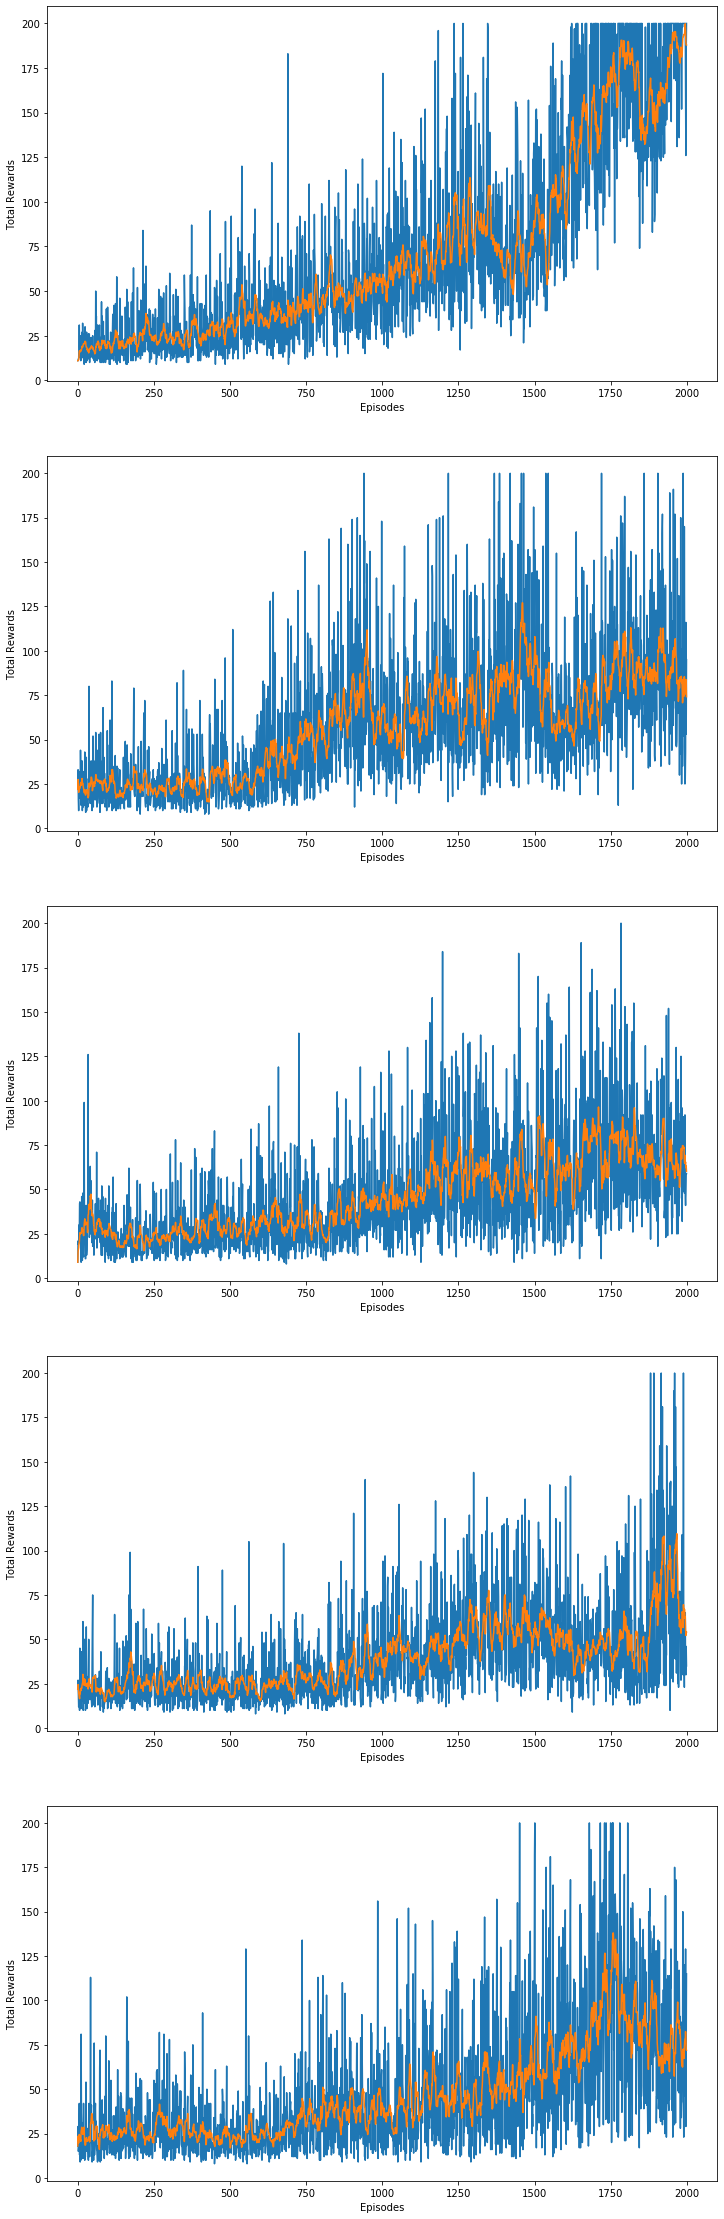

In [46]:
import time
# env = gym.make('CartPole-v0')
# env = gym.make("Acrobot-v1")
# env = gym.make("MountainCar-v0")
# env._max_episode_steps = 1000
# add in 1000 steps if this doesn't work!
# seed = env.seed()
# pe = policy_estimator(env)


fig, axs = plt.subplots(5,1, figsize = (12,40))
for run in range(5):
    # Create a new environment instance (seed is different at each run)
#     env = gym.make("MountainCar-v0")
#     env._max_episode_steps = 1000
    env = gym.make('CartPole-v0')
    seed = env.seed()
    pe = policy_estimator(env)
    
    
    start = time.time()
    rewards = reinforce(env, pe)
    
    end = time.time()
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    window = 10
    smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                        else np.mean(rewards[:i+1]) for i in range(len(rewards))]
    
    axs[run].plot(rewards)
    axs[run].plot(smoothed_rewards)
    axs[run].set_ylabel('Total Rewards')
    axs[run].set_xlabel('Episodes')
    
#     plt.figure(figsize=(12,8))
#     plt.plot(rewards)
#     plt.plot(smoothed_rewards)
#     plt.ylabel('Total Rewards')
#     plt.xlabel('Episodes')
plt.show()

In [ ]:
fig.savefig("policygradient_mountainCar-1.png")

# My best implementation (with this guide above as reference)

In [34]:
# Initialize Policy parameter theta (e.g. to 0 vector) -- currently I am going with assumption that they are already initialized
# help(pe.zero_grad) # This is also something that I didn't do. This could be important (to prevent building up of gradients)
print(pe.parameters())

<generator object Module.parameters at 0x000001D3EFC64048>


In [81]:
type(env.reset())

numpy.ndarray

In [3]:
#Pick an action





state = torch.from_numpy(env.reset()).float()
print(action_choice(pe, state))

tensor([-0.5891,  0.0000])
[0.3804588  0.314339   0.30520222]
(1, 0.314339)


In [2]:
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
import torch
print(torch.__version__)
import gym
from evaluation import evaluate
# For sanity, have set the seed on all possible variables

# Input differentiable policy parameterization & Step size
STEP_SIZE = 0.01


class PolicyEstimator(nn.Module):
    def __init__(self, env):
        super(PolicyEstimator,self).__init__()
        
        self.n_input = env.observation_space.shape[0]
        self.n_output = env.action_space.n
        self.fc1 = nn.Linear(self.n_input, 16)
        self.fc2 = nn.Linear(16, self.n_output)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = -1)
        return x

    
# Test of output
env = gym.make("MountainCar-v0")

state = torch.tensor(env.reset()).float()
print(state)
pe = PolicyEstimator(env)
print(pe(state).sum()) # Softmax that should add up to 1

1.1.0
tensor([-0.4132,  0.0000])
tensor(1., grad_fn=<SumBackward0>)


In [17]:
#Pick an action
def action_choice(policy_estimator, state):
    # May cause conflicts with the Maze environment
    action_probs = policy_estimator(state).detach().numpy()
    action = np.random.choice((policy_estimator.n_output), p = action_probs)
    idx = action_probs[action]
    return action, idx

def discount_rewards(reward_array, DISCOUNT = 0.99):
    '''
    This will take the reward, and recursively update them, in reverse.
    
    input: reward_array[list]: list of rewards that are generated per episode
    
    '''
    
#     reward_array = torch.FloatTensor(reward_array)
    G = torch.zeros((len(reward_array),)).float()
    cumulative = 0
    for i in reversed(range(len(reward_array)-1)):
        G[i] = reward_array[i+1] + DISCOUNT * G[i+1]
    return G



# Generate an episode (loop forever [actually until episode is done, because it's continuous])


def generate_episode(env, policy_estimator):
    done = False

    action_prob_val = []
    action_list = []
    state_list = []
    s_0 = torch.from_numpy(env.reset()).float() # Initial state
    cumulative_reward = 0
    reward_list = []
    while not done:
        # Pick an action, and step through environment
        action, prob = action_choice(pe, s_0)

        # Append this before. Then you'll get the same size
        state_list.append(s_0)

        s_1, reward, done, _ = env.step(action)
        cumulative_reward += reward
        action_prob_val.append(prob)
        reward_list.append(reward)
        action_list.append(action)
        s_0 = torch.from_numpy(s_1).float() # Make state the next one
            
    return cumulative_reward, reward_list, action_list, state_list


def reinforce(env, policy_estimator, EPISODES = 2000, baseline = False):
    
    cumulative_reward = []
    optimizer = optim.Adam(pe.parameters())

    for episode in range(EPISODES):
        cum_rewards, reward_list, action_list, state_list = generate_episode(env, policy_estimator)
        cumulative_reward.append(cum_rewards)

        # Compute loss
        reward_tensor = torch.tensor(reward_list).float()
        action_tensor = torch.tensor(action_list).long()
        state_tensor = torch.stack(state_list)
        # Goal is to make sure that when estimating, you are simulating the same conditions
        # I don't think that setting the seed is the right way to do it. I prob should confirm whether I get the same value or not.


        # Does this need to be seeded?
        action_output = torch.log(policy_estimator(state_tensor))

        # This is just doing an indexing! It picks the action that was chosen in the run. There is no operation here that pytorch has to track
        picked_logprob = action_output[np.arange(len(action_tensor)), action_tensor]

        return_tensor = discount_rewards(reward_tensor)
        # print(return_tensor[-10:])

        # loss has negative sign, because we are doing gradient ascent
        loss = torch.sum(-return_tensor * picked_logprob)
    #     loss_list.append(loss)
        print(f'\r episode {episode} -------- loss {loss}', end = " ")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return cumulative_reward




# # MAKE SURE that you have things seeded. That likely makes things easier. Randomize the seed that you choose I guess. Is there another way to do it?
# # np.random.seed(0)
# # torch.manual_seed(0)
# # env.seed(0)

# env = gym.make("MountainCar-v0")
# env._max_episode_steps = 1000
# seed = env.seed(0)

# c_reward, rewards, actions, states = generate_episode(env, pe)

# print(c_reward)
# print(len(rewards))
# print(len(actions))
# print(len(states))




In [ ]:
import matplotlib.pyplot as plt
# env = gym.make("MountainCar-v0")
# env._max_episode_steps = 1000
env = gym.make("CartPole-v0")
EPISODES = 2000
pe = PolicyEstimator(env)

# optimizer = optim.SGD(pe.parameters(), lr=0.1)
rewards = reinforce(env,pe)

window = 10
smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                        else np.mean(cumulative_reward[:i+1]) for i in range(len(cumulative_reward))]


fig, axs = plt.subplots(1,1, figsize = (15,11))
axs.plot(rewards)
axs.plot(smoothed_rewards)
axs.set_xlabel("Episodes")
axs.set_ylabel("Rewards")
axs.legend(['Cumulative reward', 'Smoothed reward'])

plt.show()

In [23]:
%whos

Variable            Type               Data/Info
------------------------------------------------
EPISODES            int                2000
F                   module             <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
PolicyEstimator     type               <class '__main__.PolicyEstimator'>
STEP_SIZE           float              0.01
action_choice       function           <function action_choice at 0x00000246F12116A8>
action_list         list               n=24
action_output       Tensor             tensor([[-4.6805, -0.0093<...>], grad_fn=<LogBackward>)
action_tensor       Tensor             tensor([1, 1, 1, 0, 1, 0,<...> 0, 0, 0, 0, 1, 1, 0, 0])
actions             list               n=1000
axs                 AxesSubplot        AxesSubplot(0.125,0.125;0.775x0.755)
c_reward            float              -1000.0
cum_rewards         float              24.0
cumulative_reward   list               n=542
discount_rewards    function           <function discount_rewards a

In [12]:
# Integration testing. Goal is to get all the way back to the parameters of NN. The reason the other person re-did all the tensors was because of backprop in Pytorch

# Change of plans, will start from the beginning

reward_tensor = torch.tensor(reward_list).float()
action_tensor = torch.tensor(action_list).long()
state_tensor = torch.stack(state_list)
# Goal is to make sure that when estimating, you are simulating the same conditions
# I don't think that setting the seed is the right way to do it. I prob should confirm whether I get the same value or not.


# Does this need to be seeded?
action_output = torch.log(pe(state_tensor))

# This is just doing an indexing! It picks the action that was chosen in the run. There is no operation here that pytorch has to track
picked_logprob = action_output[np.arange(len(action_tensor)), action_tensor]

return_tensor = discount_rewards(reward_tensor)
# print(return_tensor[-10:])

loss = torch.sum(-return_tensor * picked_logprob)
print(loss)

tensor(-98241.0859, grad_fn=<SumBackward0>)


In [8]:
# Get the return values as well


print(loss)

loss.backward()

tensor(-98241.0859, grad_fn=<SumBackward0>)


In [3]:
from evaluation import evaluate
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
# importlib.reload(evaluation)
    
def action_choice(policy_estimator, state):
    # May cause conflicts with the Maze environment
    state = state.unsqueeze(0)[0]
    action_probs = policy_estimator(state).detach().numpy()
    action = np.random.choice((policy_estimator.n_output), p = action_probs)
    return action
    
def discount_rewards(reward_array, DISCOUNT = 0.99):
    '''
    This will take the reward, and recursively update them, in reverse.
    
    '''
    
#     reward_array = torch.FloatTensor(reward_array)
    G = torch.zeros((len(reward_array),)).float()
    cumulative = 0
    for i in reversed(range(len(reward_array)-1)):
        G[i] = reward_array[i+1] + DISCOUNT * G[i+1]
    return G

def reinforce(env, policy_estimator, DISCOUNT = 0.99, EPISODES = 2000, lr = 0.01, EVALUATION_STEP = 400):
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.parameters(), lr = lr)

    cumulative_reward = []
    running_reward = 0
    
    steps = []
    eval_reward = []
        
    
    # Update over X number of episodes (default 2000)
    for ep in range(EPISODES):
        
        # Evaluate every Y episodes (default 400). Add reward step each iteration
        if ep % EVALUATION_STEP == 0:
            st, er = evaluate(env, Q_table = None, step_bound = 100, num_itr = 10, Gym = True, policy_estimator = policy_estimator)
            steps.append(st)
            eval_reward.append(er)

        # Generate episode, save all states inside the episode
        states, actions, rewards = generate_episode(env, policy_estimator)
        
        # Record running reward
        running_reward += sum(rewards)
        cumulative_reward.append(running_reward)
        
        
        # Create discounted reward array for each iteration of episode
        G = discount_rewards(rewards, DISCOUNT)

        
        
        # Convert arrays to tensor form
        
        
        action_tensor = torch.LongTensor(actions)
        states_tensor = torch.tensor(states).float()
        reward_tensor = torch.tensor(G).float()

        

# #############################################
#         Baseline##########
#         WINDOW = 20
#         baseline = np.mean(reward_tensor[-WINDOW:].detach().numpy())
#         reward_with_baseline = reward_tensor - baseline
#           selected_logprobs = reward_with_baseline * logprob[np.arange(len(action_tensor)), action_tensor]
# #############################################      
        
    # Find the loss function
        logprob = torch.log(policy_estimator(states_tensor))
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss = -selected_logprobs.sum()
        
        print("\r Ep {}/{} running reward: {}, loss {}".format(ep, EPISODES, running_reward, loss), end = "")
        
        #Backprop & update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Clear values for new episode
        states = []
        actions = []
        rewards = []

    return cumulative_reward, steps, eval_reward
                
                
                
        
        
        
        
    
    

In [ ]:
# 5 different seeds


fig, axs = plt.subplots(5,1, figsize = (12,40))
for run in range(5):
    # Create a new environment instance (seed is different at each run)
    env = gym.make("MountainCar-v0")
    env._max_episode_steps = 1000
    seed = env.seed()
    pe = policy_estimator(env)
    
    
    start = time.time()
    rewards = reinforce(env, pe)
    
    end = time.time()
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    window = 10
    smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                        else np.mean(rewards[:i+1]) for i in range(len(rewards))]
    
    axs[run].plot(rewards)
    axs[run].plot(smoothed_rewards)
    axs[run].set_ylabel('Total Rewards')
    axs[run].set_xlabel('Episodes')



    
    

In [ ]:
# 
fig, axs = plt.subplots(1,1,figsize= (15,11))
seeds = []

import time
import matplotlib.pyplot as plt


for run in range(5):
    env = gym.make("Acrobot-v1")
#     env._max_episode_steps = 1000
    seed = env.seed()
    seeds.append(seed)
    pe = PolicyEstimator(env)
    
    
    start = time.time()
    cum_reward = reinforce(env, pe)
    
    end = time.time()
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    axs.plot(cum_reward)
    axs.set_ylabel("Cumulative reward")
    axs.set_xlabel("Episodes")
    axs.legend(seeds)
plt.show()

# Attempt with class evaluation script

In [ ]:
import time
import matplotlib.pyplot as plt

RUNS = 2 # number of different seeds you are trying out - checking by eye for variance


fig, axs = plt.subplots(RUNS,1,figsize= (15 * RUNS,11))
seeds = []




for run in range(RUNS):
    env = gym.make("Acrobot-v1")
#     env._max_episode_steps = 1000
    seed = env.seed()
    seeds.append(seed)
    pe = PolicyEstimator(env)
    
    
    start = time.time()
    cum_reward, steps, eval_reward = reinforce(env, pe, EPISODES = 2000)
    
    end = time.time()
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    axs[0].plot(steps)
    axs[0].set_ylabel("Steps taken")
    axs[0].set_xlabel("Episodes")
    axs[0].legend(seeds)
    
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    axs[1].plot(eval_reward)
    axs[1].set_ylabel("Cumulative reward")
    axs[1].set_xlabel("Episodes")
    axs[1].legend(seeds)
plt.show()

In [ ]:
print(steps)
print(eval_reward)

In [ ]:
%whos




In [5]:
from maze import *
import gym
import time
import sys
import numpy as np
import argparse
import evaluation
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

class MDP(Maze):
    '''
    Inherits all the attributes from the maze
    '''
    def __init__(self):
        super().__init__()
        # self.LEARNING_RATE = 0.1

        
        
        
class PolicyEstimator(nn.Module):
    '''
    Feedforward network definition for maze environment
    
    '''
    def __init__(self, env):
        super(PolicyEstimator,self).__init__()

        self.n_input = 1
        self.n_output = env.anum


        self.fc1 = nn.Linear(self.n_input, 16)
        self.fc2 = nn.Linear(16, self.n_output)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = -1)
        return x        
    
    

    

env = MDP()

state = torch.tensor(env.reset()).float().unsqueeze(0) # unsqueeze adds a fake batch dimension
print(state)
net = PolicyEstimator(env)
output = net(state)
print(output)

tensor([0.])
tensor([0.2792, 0.3435, 0.1829, 0.1944], grad_fn=<SoftmaxBackward>)


In [10]:
env = MDP()
print(type(env.reset()))
env2 = gym.make("CartPole-v0")
print(type(env2.reset()))

<class 'int'>
<class 'numpy.ndarray'>


In [ ]:

evaluate(env, policy_estimator= net)

In [ ]:
RUNS = 2
env = 
for run in range(RUNS):
#     env = gym.make("Acrobot-v1")
#     env._max_episode_steps = 1000
#     seed = env.seed()
#     seeds.append(seed)
    pe = PolicyEstimator(env)
    
    
    start = time.time()
    cum_reward, steps, eval_reward = reinforce(env, pe, EPISODES= 2000)
    
    end = time.time()
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    axs[0].plot(steps)
    axs[0].set_ylabel("Steps taken")
    axs[0].set_xlabel("Episodes")
#     axs[0].legend(seeds)
    
    print(f'time of run {run} for seed {seed} in minutes: {(end-start) / 60.}')
    axs[1].plot(eval_reward)
    axs[1].set_ylabel("Cumulative reward")
    axs[1].set_xlabel("Episodes")
#     axs[1].legend(seeds)
plt.show()